# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [167]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
%matplotlib inline

In [168]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [169]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [170]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [171]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [172]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,34200,3600,3600,3600,3600,103,3600,3600,0.0,0.0,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000
unique,36,36,36,13,7,29,1036,1037,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
top,2019-08,2019-04,2019-08,2018-10,2018-11,2019-01-12,2021-04-21,2019-03-26,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01
freq,1050,123,128,337,612,11,11,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,5013.894222,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2871.273888,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2536.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5010.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7492.000000,NaN


## Data Preparation

In [173]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat',
       'admitted_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3',
       'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3',
       'lrti_date_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa',
       'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count',
       'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_prescriptions',
       'antibacterial_brit', 'broad_spectrum_antibiotics_prescriptions',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [174]:
# define dictionaries

dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [175]:
# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [176]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] == 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

#### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [177]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [178]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

3.0     4762
2.0     4707
4.0     4214
1.0     4190
0.0     3492
5.0     3155
6.0     2833
7.0     2226
8.0     1713
9.0     1333
10.0    1109
11.0     814
12.0     562
13.0     368
14.0     183
15.0     130
16.0      87
17.0      57
18.0      31
19.0      19
20.0       7
21.0       7
22.0       1
Name: CCI, dtype: int64

## Plots continuous factors

In [27]:
# function to generate histogram plots
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

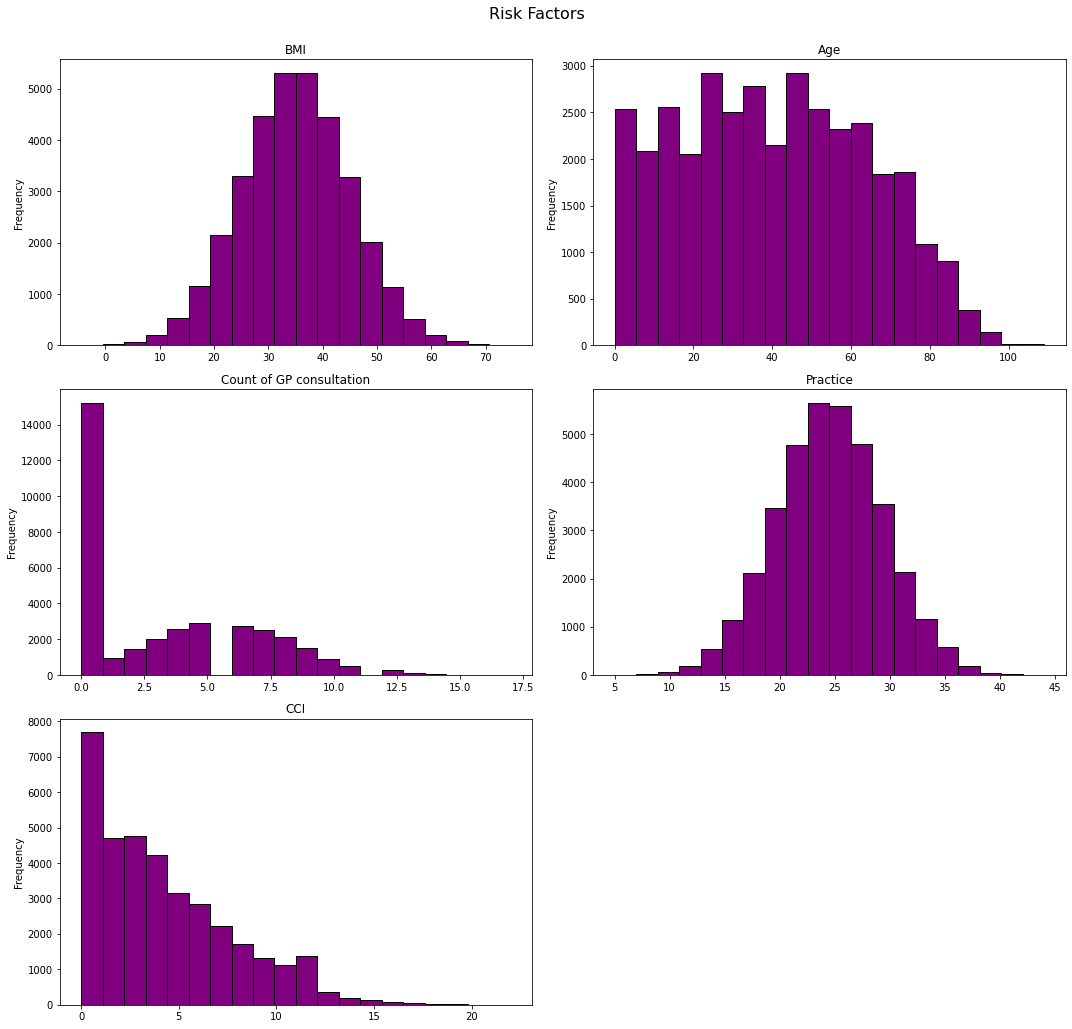

In [30]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

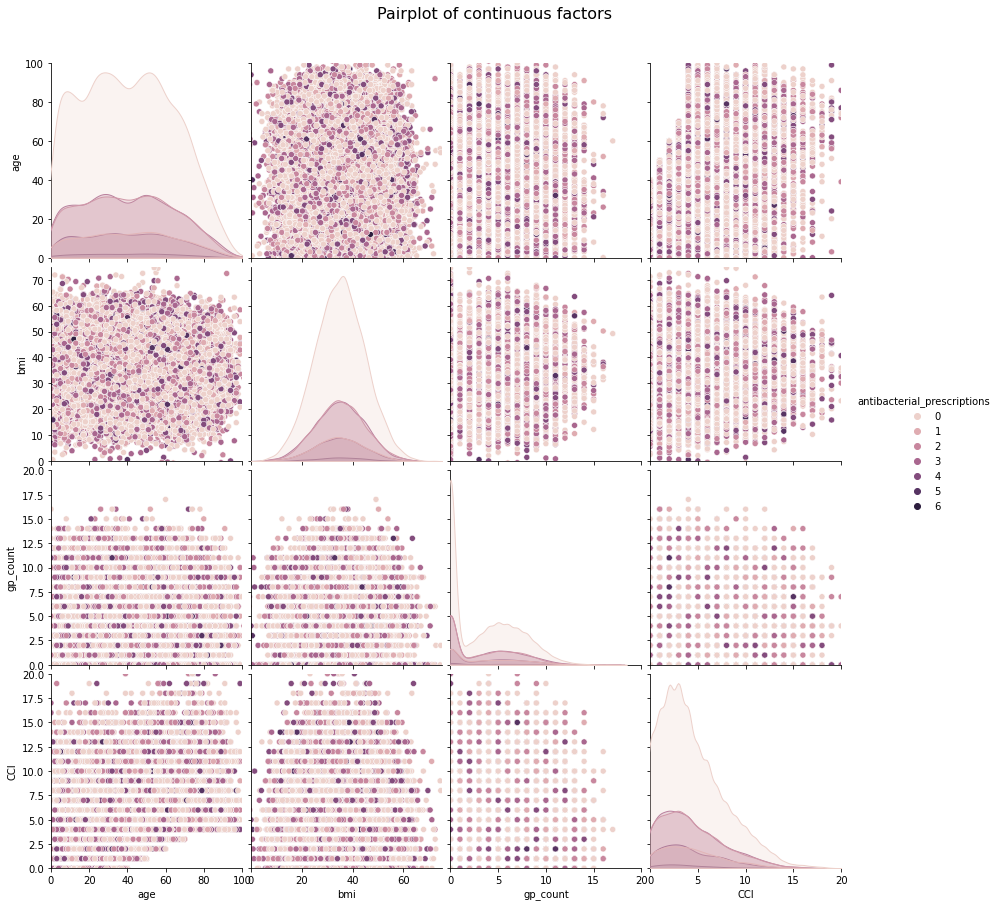

In [37]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'antibacterial_prescriptions', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
#                'scatter_kws': {'alpha': 0.2}}, 
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

## Plot categorical factors

In [179]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)

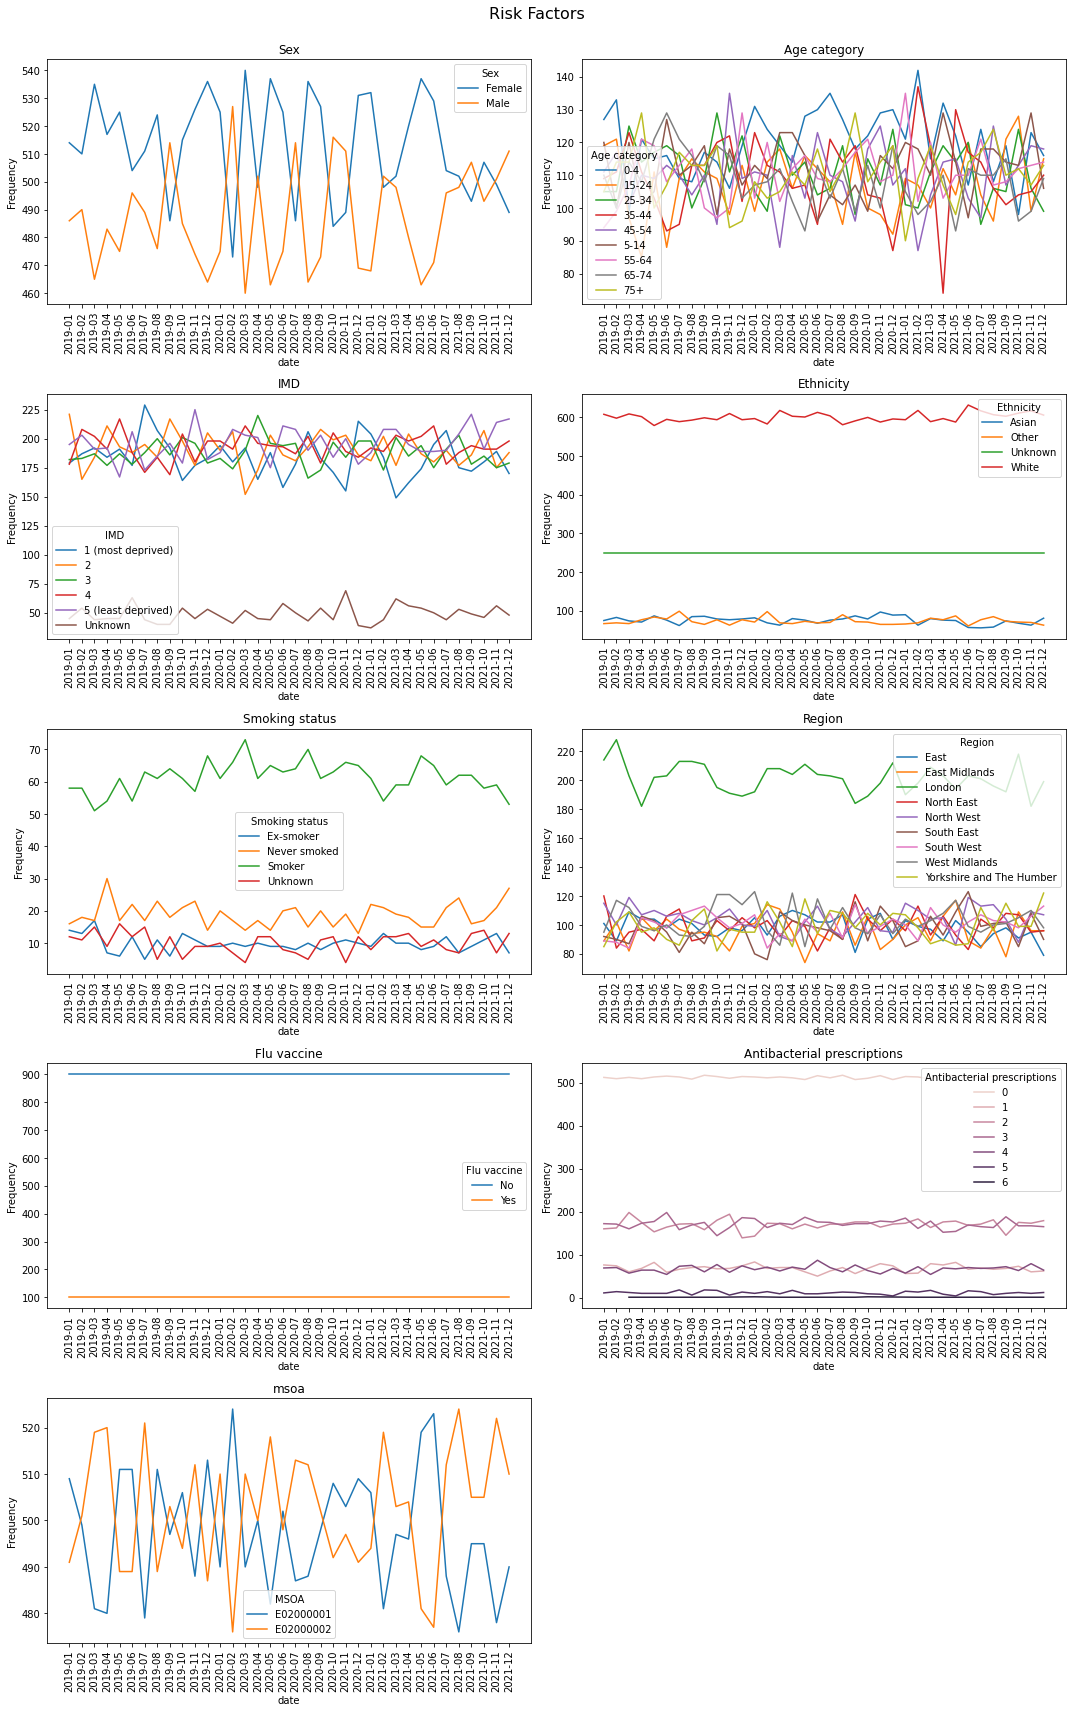

In [180]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('region', 'Region', 'Region', axes[2,1])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[3,0])
create_lineplot('antibacterial_prescriptions', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[3,1])
create_lineplot('msoa', 'msoa', 'MSOA', axes[4,0])
fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## Hospital admissions related to infections 

Q1- should we not exclude those who are admitted due to covid, not those who were diagnosed with covid 3 months before or two weeks after?

Q2- what is the difference between primary_care_covid and sgss_positive? seems like the first one is broader, right?

### 1- Data preparation for hospital admission prediction with negative binomial regression
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission. 

In [181]:
data['primary_care_covid'] = data['primary_care_covid'].astype('datetime64[ns]')
data['sgss_positive'] = data['sgss_positive'].astype('datetime64[ns]')
data['admitted_date'] = data['admitted_date'].astype('datetime64[ns]')

In [182]:
# exclusion
# calculation of delta of hospital admission date and primary care diagnosis of covid
#data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['primary_care_covid']).dt.days
data['delta_primary_care_covid_admitted'] = (data['admitted_date'] - data['sgss_positive']).dt.days
data['delta_primary_care_covid_admitted'].value_counts()

-307.0    4
 6.0      4
 11.0     4
 360.0    4
 212.0    4
         ..
-271.0    1
-365.0    1
 746.0    1
-265.0    1
 692.0    1
Name: delta_primary_care_covid_admitted, Length: 785, dtype: int64

In [183]:
data['delta_primary_care_covid_admitted'][data['delta_primary_care_covid_admitted'] > 90] = np.nan ###it must be 90
data['delta_primary_care_covid_admitted'][data['delta_primary_care_covid_admitted'] < -30] = np.nan ### it must be -30
data['delta_primary_care_covid_admitted'].value_counts()

 11.0    4
-10.0    4
 6.0     4
 5.0     3
 50.0    3
        ..
 59.0    1
-16.0    1
 76.0    1
 55.0    1
 66.0    1
Name: delta_primary_care_covid_admitted, Length: 75, dtype: int64

In [184]:
data.loc[:, ['sgss_positive', 'primary_care_covid', 'admitted_date', 'delta_primary_care_covid_admitted', 'date']]

,sgss_positive,primary_care_covid,admitted_date,delta_primary_care_covid_admitted,date
0,2019-08-12,NaT,2021-01-13,NaN,2019-01
1,NaT,2021-04-08,2021-07-08,NaN,2019-01
2,2021-06-13,NaT,NaT,NaN,2019-01
3,NaT,NaT,NaT,NaN,2019-01
4,NaT,NaT,2021-01-31,NaN,2019-01
...,...,...,...,...,...
35995,NaT,2019-01-25,NaT,NaN,2021-12
35996,NaT,NaT,NaT,NaN,2021-12
35997,NaT,NaT,NaT,NaN,2021-12
35998,NaT,NaT,NaT,NaN,2021-12


In [185]:
data['delta_primary_care_covid_admitted'].value_counts()

 11.0    4
-10.0    4
 6.0     4
 5.0     3
 50.0    3
        ..
 59.0    1
-16.0    1
 76.0    1
 55.0    1
 66.0    1
Name: delta_primary_care_covid_admitted, Length: 75, dtype: int64

In [186]:
data['delta_primary_care_covid_admitted'].value_counts().sum()

112

In [187]:
# calculate absolute values for all rows in delta_primary_care_covid_admitted column
data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted'].abs()

data['delta_primary_care_covid_admitted_abs'].value_counts()

11.0    5
5.0     4
6.0     4
10.0    4
50.0    3
       ..
60.0    1
70.0    1
61.0    1
75.0    1
66.0    1
Name: delta_primary_care_covid_admitted_abs, Length: 62, dtype: int64

In [188]:
data['delta_primary_care_covid_admitted_abs'].value_counts().sum()

112

In [189]:
data['delta_primary_care_covid_admitted_binary'] = data['delta_primary_care_covid_admitted_abs'].mask(data['delta_primary_care_covid_admitted_abs'] > 0, 1)
data['delta_primary_care_covid_admitted_binary'] = data['delta_primary_care_covid_admitted_binary'].fillna(0)
data['delta_primary_care_covid_admitted_binary'].value_counts()

0.0    35888
1.0      112
Name: delta_primary_care_covid_admitted_binary, dtype: int64

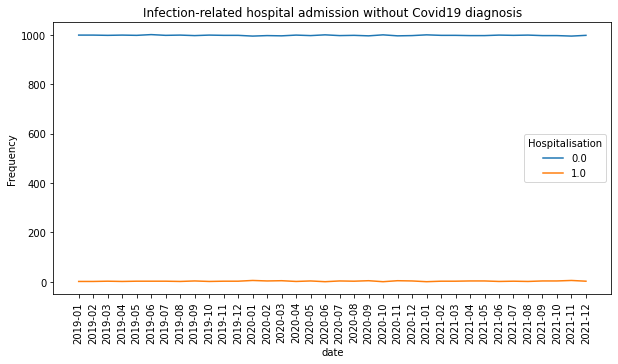

In [190]:
fig, ax1 = pyplot.subplots(figsize=(10, 5))
create_lineplot('delta_primary_care_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', ax1)
#plt.legend(title="Legend Title")
# plt.savefig(r'../output/hospitalisation_risk/Infection-related hospitalisation, no covid.jpg')
plt.show()

In [191]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)

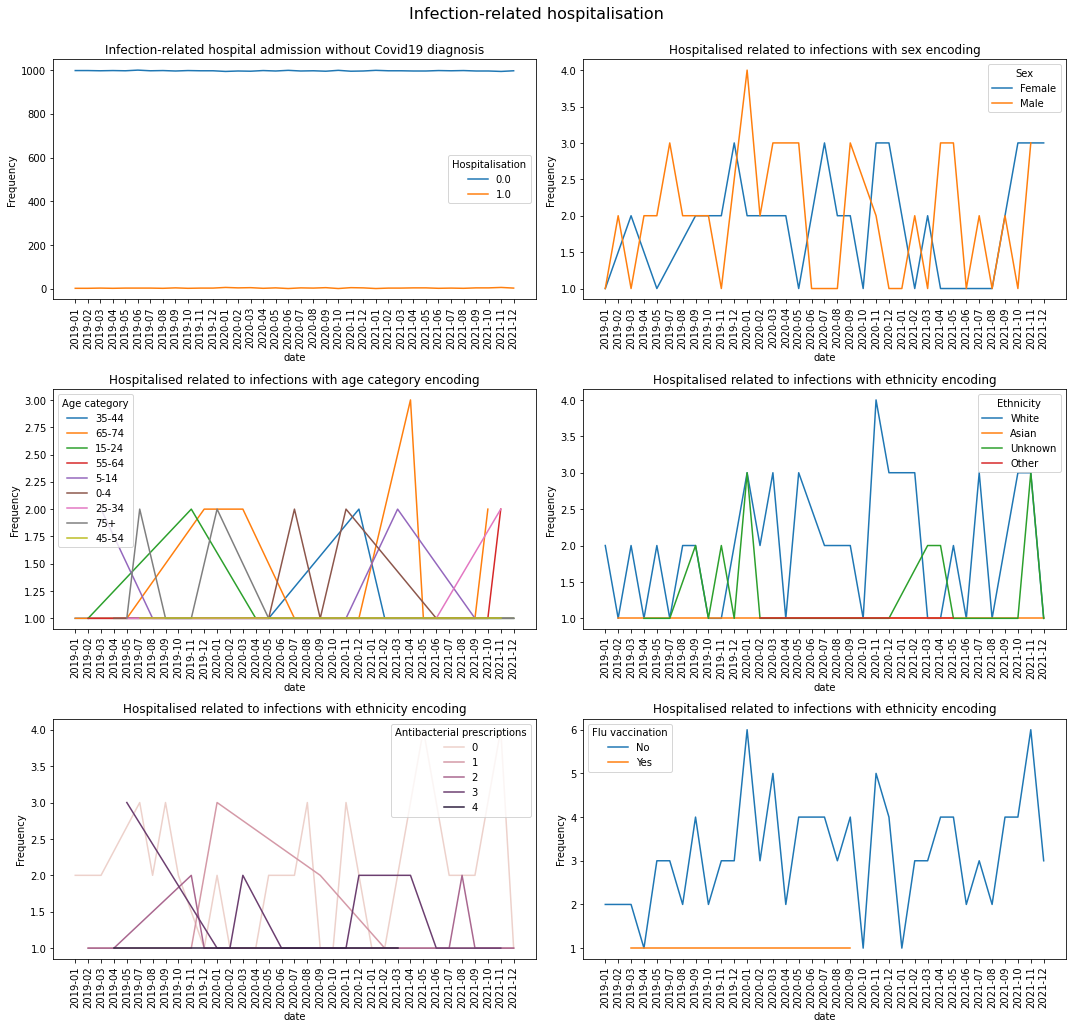

In [192]:
fig, axes = plt.subplots(3,2,
                        figsize=(15, 15)
                        )

create_lineplot('delta_primary_care_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', axes[0,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'sex', 'Hospitalised related to infections with sex encoding', 'Sex', axes[0,1])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'age_cat', 'Hospitalised related to infections with age category encoding', 'Age category', axes[1,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'ethnicity', 'Hospitalised related to infections with ethnicity encoding', 'Ethnicity', axes[1,1])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'antibacterial_prescriptions', 'Hospitalised related to infections with ethnicity encoding', 'Antibacterial prescriptions', axes[2,0])
create_lineplot_hue('delta_primary_care_covid_admitted_binary', 'flu_vaccine', 'Hospitalised related to infections with ethnicity encoding', 'Flu vaccination', axes[2,1])

#fig.delaxes(ax=axes[1,1])

fig.suptitle('Infection-related hospitalisation', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/infection-related hospitalisation.jpg')
plt.show()

In [151]:
# # select patients whom their delta date is between 90 and -30
# data_hosp = data[~data['delta_primary_care_covid_admitted'].isnull()]
# data_hosp.head()

### 2- Negative binomial regression

For negative binomial regression (NB2), a 5-step method is proposed in https://timeseriesreasoning.com/contents/negative-binomial-regression-model/. These steps are:
<ol>
  <li>Poisson regression to obtain the vector of fitted rates of lambda.</li>
  <li>Auxiliary OLS (ordinary least squares) regression to obtain the value of alpha.</li>
  <li>Fit NB2 regression model to the data with the obtained alpha.</li>
  <li>Fit NB2 model to the test data set and test the goodness of the model.</li>
</ol>

In [125]:
data.admitted.value_counts()

0    32400
1     3600
Name: admitted, dtype: int64

#### 2-1- Poisson regression for lambda calculation

In [126]:
# # define a column of month and day
# data_hosp['admitted_month'] = data_hosp.admitted_date.dt.month
# data_hosp['admitted_day'] = data_hosp.admitted_date.dt.day

In [127]:
# # split data into 80% training and 20% testing
# mask = np.random.rand(len(data_hosp)) < 0.8
# data_hosp_train = data_hosp[mask]
# data_hosp_test = data_hosp[~mask]
# print(f'data train: {data_hosp_train.shape}')
# print(f'data test: {data_hosp_test.shape}')

In [128]:
# # set up a regression expression
# expr_data_hosp = """admitted ~ admitted_month + admitted_day + age + sex + imd"""
# #expr_data_hosp = """admitted ~ admitted_date + age + sex + imd"""

In [129]:
# # set up the training and testing of the poisson regression
# y_train, X_train = dmatrices(expr_data_hosp, data_hosp_train, return_type='dataframe', NA_action='drop')
# y_test, X_test = dmatrices(expr_data_hosp, data_hosp_test, return_type='dataframe', NA_action='drop')

In [130]:
# print(f'y_train: {y_train.shape}')
# print(f'X_train: {X_train.shape}')
# print(f'y_test: {y_test.shape}')
# print(f'X_test: {X_test.shape}')

In [131]:
# X_train.head()

In [132]:
# X_test.head()

In [133]:
# from sklearn.model_selection import train_test_split
# X = data_hosp[['admitted_month', 'admitted_day', 'age', 'sex', 'imd']]
# y = data_hosp['admitted']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [134]:
# print(f'y_train: {y_train.shape}')
# print(f'X_train: {X_train.shape}')
# print(f'y_test: {y_test.shape}')
# print(f'X_test: {X_test.shape}')

In [135]:
# # use generalised linear models (GLM) class of statsmodels package to train the poisson regression model
# poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [136]:
# print(poisson_training_results.summary())

In [137]:
# # print the vectore of fitted rates of lambda produced by the training
# print(poisson_training_results.mu)

In [138]:
# # compuet the length of mu
# print(len(poisson_training_results.mu))

#### 2-2- Auxiliary OLS (ordinary least squares) regression

In [139]:
# # define a variables called lambda with values from the poisson regression
# data_hosp_train['lambda'] = poisson_training_results.mu

In [140]:
# # calculate the values of the dependant variable of ols regression
# data_hosp_train['AUX_OLS_DEP'] = data_hosp_train.apply(lambda x: ((x['admitted'] - x['lambda'])**2 - x['lambda']) / x['lambda'], axis=1)

In [141]:
# # # calculate ols regression with a regression expression defined in the formula parameter
# aux_olsr_results = smf.ols(formula = "Q('AUX_OLS_DEP') ~ Q('lambda') - 1", data = data_hosp_train).fit()

In [142]:
# print(aux_olsr_results.params)

In [143]:
# aux_olsr_results.tvalues

#### 2-3- Negative binomial

In [144]:
# alpha=aux_olsr_results.params[0]
# alpha=abs(alpha)
# print(f'alpha= {alpha:.4f}')

In [145]:
# # training NB2 regression model with the training data
# # parameter alpha cannot be a negative value; so I used its absolute value. 
# # see: https://www.statsmodels.org/dev/generated/statsmodels.genmod.families.family.NegativeBinomial.html
# nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=alpha)).fit()

In [146]:
# nb2_training_results.summary()

#### 2-4- Fitting NB2 model to testing data

In [147]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)

In [148]:
# nb2predictions_summary_frame = nb2_predictions.summary_frame()
# print(nb2predictions_summary_frame)

In [149]:
# # add admitted date from data_hosp dataframe by lookup; then sorted with admitted dates
# X_test['admitted_date'] = data_hosp.admitted_date.loc[X_test.index]
# X_test = X_test.sort_values(by=['admitted_date'])

In [150]:
# NB_predicted_counts=nb2predictions_summary_frame['mean']
# actual_counts = y_test['admitted']
# fig = plt.figure(figsize=(12, 5))
# fig.suptitle('Actual values versus predicted values with negative binomial regression', fontsize=16)
# predicted, = plt.plot(X_test.admitted_date, NB_predicted_counts, 'go--', label='Predicted counts',)
# actual, = plt.plot(X_test.admitted_date, actual_counts, 'ro-', label='Actual counts')
# #plt.ylim(-0.1,1.1)
# plt.legend(handles=[predicted, actual])
# plt.xticks(rotation=25, ha='right')
# plt.grid()
# plt.tight_layout()
# plt.savefig('../output/hospitalisation_risk/actual_predicted_NB2.jpg')
# plt.show()

### 2- Negative binomial regression 

In [193]:
# define dictionaries

dict_sex = {'Female': 1, 'Male': 2}
dict_ethnicity = {'White': 1, 'Mixed': 2, 'Asian': 3, 'Black': 4, 'Other': 5, 'Unknown': 0}
dict_smoking = {'Ex-smoker': 1, 'Unknown': 2, 'Smoker': 3, 'Never smoked': 4, np.nan: 2}
dict_imd = {'Unknown': 0, '1 (most deprived)': 1, '2': 2, '3': 3, '4': 4, '5 (least deprived)': 5}
dict_flu = {'No': 0, 'Yes': 1}
#dic_delta_primary_care_covid_admitted_abs = {'No': 0, 'Yes': 1}

# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [194]:
# assigning 0 to NaN celss of delta_primary_care_covid_admitted_abs for compatibility of NB model
data['delta_primary_care_covid_admitted_abs'] = data['delta_primary_care_covid_admitted_abs'].fillna(0)
data['delta_primary_care_covid_admitted_abs'].value_counts()

0.0     35888
11.0        5
6.0         4
10.0        4
5.0         4
        ...  
60.0        1
70.0        1
61.0        1
75.0        1
66.0        1
Name: delta_primary_care_covid_admitted_abs, Length: 63, dtype: int64

In [196]:
data_NB = data.groupby(['date', 'sex']).size()#.reset_index()
data_NB.head()

date     sex
2019-01  1      514
         2      486
2019-02  1      510
         2      490
2019-03  1      535
dtype: int64

In [197]:
data_NB = data.groupby(['date']).mean()#.reset_index()
data_NB.head()

,covrx1_dat,covrx2_dat,age,sex,practice,imd,bmi,ethnicity,smoking_status,gp_count,...,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,CCI,delta_primary_care_covid_admitted,delta_primary_care_covid_admitted_abs,delta_primary_care_covid_admitted_binary
date,,,,,,,,,,,,,,,,,,,,,
2019-01,NaN,NaN,40.578,1.486,24.434,2.854,35.041677,1.168,2.076,3.428715,...,0.1,0.1,0.1,0.1,0.1,4950.415,4.443,14.500000,0.087,0.002
2019-02,NaN,NaN,39.453,1.490,24.545,2.913,34.974168,1.192,2.081,3.413724,...,0.1,0.1,0.1,0.1,0.1,5094.633,4.347,32.500000,0.101,0.002
2019-03,NaN,NaN,40.614,1.465,24.529,2.884,35.040573,1.166,2.068,3.323589,...,0.1,0.1,0.1,0.1,0.1,4961.472,4.398,24.666667,0.104,0.003
2019-04,NaN,NaN,40.320,1.483,24.487,2.861,35.109722,1.200,2.107,3.333333,...,0.1,0.1,0.1,0.1,0.1,5075.188,4.413,41.000000,0.082,0.002
2019-05,NaN,NaN,41.260,1.475,24.414,2.841,34.837915,1.260,2.089,3.361531,...,0.1,0.1,0.1,0.1,0.1,4970.181,4.503,16.000000,0.090,0.003


In [198]:
X = data_NB[['age', 
#          'sex', 
#          'ethnicity', 
#          'smoking_status', 
          'imd',
          'flu_vaccine',
          'delta_primary_care_covid_admitted_abs',
          ]]
y = data_NB['delta_primary_care_covid_admitted_binary']

In [72]:
# # splitting data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# print(f'y_train: {y_train.shape}')
# print(f'X_train: {X_train.shape}')
# print(f'y_test: {y_test.shape}')
# print(f'X_test: {X_test.shape}')

In [199]:
# nb2_training_results = sm.GLM(y_train, 
#                               X_train,
#                               family=sm.families.NegativeBinomial(alpha=1)).fit()

nb2_training_results = sm.GLM(y, 
                              X,
                              family=sm.families.NegativeBinomial(alpha=1)).fit()

In [200]:
nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Generalized Linear Model Regression Results                             
====================================================================================================
Dep. Variable:     delta_primary_care_covid_admitted_binary   No. Observations:                   36
Model:                                                  GLM   Df Residuals:                       32
Model Family:                              NegativeBinomial   Df Model:                            3
Link Function:                                          Log   Scale:                          1.0000
Method:                                                IRLS   Log-Likelihood:               -0.75177
Date:                                      Tue, 07 Dec 2021   Deviance:                     0.010976
Time:                                              20:37:01   Pearson chi2:                  0.00936
No. Iterations:                                           4   Pseudo R-squ. (CS):          0.0003865
Covariance Type:                                  nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
age                                      -0.0216      4.121     -0.005      0.996      -8.099       8.056
imd                                      -0.5324     65.553     -0.008      0.994    -129.014     127.949
flu_vaccine                             -39.6825   2775.135     -0.014      0.989   -5478.847    5399.482
delta_primary_care_covid_admitted_abs     4.9718     42.015      0.118      0.906     -77.377      87.320
=========================================================================================================
"""

In [201]:
# nb2_predictions = nb2_training_results.get_prediction(X_test)
nb2_predictions = nb2_training_results.get_prediction(X)

In [202]:
nb2predictions_summary_frame = nb2_predictions.summary_frame()
print(nb2predictions_summary_frame)

             mean   mean_se  mean_ci_lower  mean_ci_upper
date                                                     
2019-01  0.002650  0.010596   1.045356e-06   6.715787e+00
2019-02  0.002821  0.014105   1.562609e-07   5.091333e+01
2019-03  0.002835  0.009875   3.077640e-06   2.612201e+00
2019-04  0.002589  0.010071   1.265928e-06   5.296303e+00
2019-05  0.002668  0.014498   6.331837e-08   1.124551e+02
2019-06  0.001699  0.011326   3.592953e-09   8.032476e+02
2019-07  0.002658  0.033477   5.075230e-14   1.392420e+08
2019-08  0.002276  0.012200   6.237427e-08   8.306588e+01
2019-09  0.002821  0.011886   7.322843e-07   1.087076e+01
2019-10  0.003492  0.015142   7.110054e-07   1.714872e+01
2019-11  0.003057  0.019245   1.337567e-08   6.985887e+02
2019-12  0.003795  0.018617   2.529812e-07   5.692136e+01
2020-01  0.005081  0.027495   1.259541e-07   2.049967e+02
2020-02  0.002217  0.017812   3.222561e-10   1.525718e+04
2020-03  0.003928  0.018125   4.633575e-07   3.329144e+01
2020-04  0.002

In [203]:
# X_test = X_test.apply(lambda x: x.sort_values(ascending=False))
# X_test

X = X.apply(lambda x: x.sort_values(ascending=False))
X

,age,imd,flu_vaccine,delta_primary_care_covid_admitted_abs
date,,,,
2019-01,40.578,2.854,0.1,0.087
2019-02,39.453,2.913,0.1,0.101
2019-03,40.614,2.884,0.1,0.104
2019-04,40.320,2.861,0.1,0.082
2019-05,41.260,2.841,0.1,0.090
2019-06,40.760,2.869,0.1,0.000
2019-07,39.062,2.732,0.1,0.068
2019-08,40.688,2.836,0.1,0.055
2019-09,40.546,2.840,0.1,0.098


In [204]:
# add admitted date from data_hosp dataframe by lookup; then sorted with admitted dates
#X_test['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X_test.index]
X['delta_primary_care_covid_admitted_abs'] = data_NB['delta_primary_care_covid_admitted_abs'].loc[X.index]
#X_test = X_test.sort_values(by=['delta_primary_care_covid_admitted_abs'])

In [205]:
X

,age,imd,flu_vaccine,delta_primary_care_covid_admitted_abs
date,,,,
2019-01,40.578,2.854,0.1,0.087
2019-02,39.453,2.913,0.1,0.101
2019-03,40.614,2.884,0.1,0.104
2019-04,40.320,2.861,0.1,0.082
2019-05,41.260,2.841,0.1,0.090
2019-06,40.760,2.869,0.1,0.000
2019-07,39.062,2.732,0.1,0.068
2019-08,40.688,2.836,0.1,0.055
2019-09,40.546,2.840,0.1,0.098


In [206]:
y

date
2019-01    0.002
2019-02    0.002
2019-03    0.003
2019-04    0.002
2019-05    0.003
2019-06    0.000
2019-07    0.003
2019-08    0.002
2019-09    0.004
2019-10    0.002
2019-11    0.003
2019-12    0.003
2020-01    0.006
2020-02    0.004
2020-03    0.005
2020-04    0.002
2020-05    0.004
2020-06    0.001
2020-07    0.004
2020-08    0.003
2020-09    0.005
2020-10    0.001
2020-11    0.005
2020-12    0.004
2021-01    0.001
2021-02    0.003
2021-03    0.003
2021-04    0.004
2021-05    0.004
2021-06    0.002
2021-07    0.003
2021-08    0.002
2021-09    0.004
2021-10    0.004
2021-11    0.006
2021-12    0.003
Name: delta_primary_care_covid_admitted_binary, dtype: float64

In [207]:
NB_predicted_counts=nb2predictions_summary_frame['mean']
NB_predicted_counts

date
2019-01    0.002650
2019-02    0.002821
2019-03    0.002835
2019-04    0.002589
2019-05    0.002668
2019-06    0.001699
2019-07    0.002658
2019-08    0.002276
2019-09    0.002821
2019-10    0.003492
2019-11    0.003057
2019-12    0.003795
2020-01    0.005081
2020-02    0.002217
2020-03    0.003928
2020-04    0.002064
2020-05    0.003392
2020-06    0.001758
2020-07    0.004192
2020-08    0.002391
2020-09    0.005711
2020-10    0.001691
2020-11    0.004564
2020-12    0.003066
2021-01    0.001824
2021-02    0.002744
2021-03    0.002263
2021-04    0.004414
2021-05    0.003005
2021-06    0.003366
2021-07    0.001935
2021-08    0.001763
2021-09    0.003273
2021-10    0.004913
2021-11    0.006311
2021-12    0.002774
Name: mean, dtype: float64

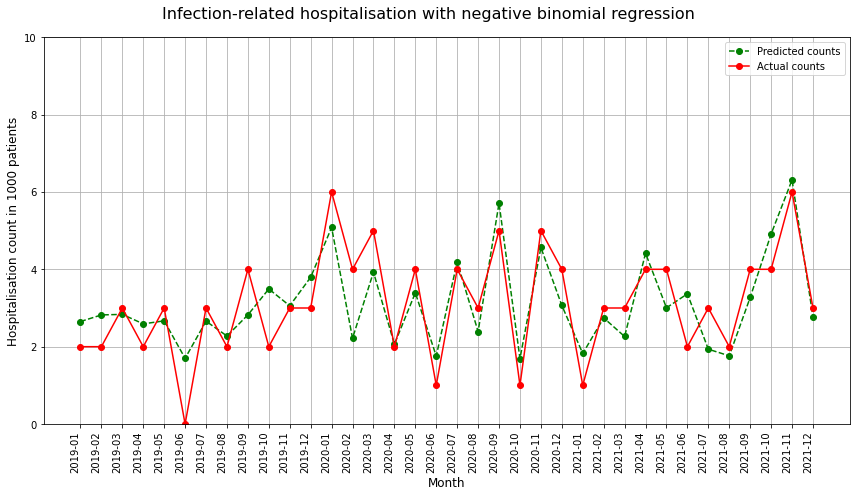

In [210]:
NB_predicted_counts=nb2predictions_summary_frame['mean']*1000
#actual_counts = y_test*1000
actual_counts = y*1000
fig = plt.figure(figsize=(12, 7))
fig.suptitle('Infection-related hospitalisation with negative binomial regression', fontsize=16)
# predicted, = plt.plot(X_test.index, NB_predicted_counts, 'go--', label='Predicted counts',)
# actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X.index, NB_predicted_counts, 'go--', label='Predicted counts',)
actual, = plt.plot(X.index, actual_counts, 'ro-', label='Actual counts')
#plt.ylim(-0.1,1.1)
plt.legend(handles=[predicted, actual])
plt.xticks(rotation=90, ha='right')
plt.grid()
plt.ylabel('Hospitalisation count in 1000 patients', fontsize='12')
plt.xlabel('Month', fontsize='12')
plt.ylim(0,10)
plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/NB2_hosp.jpg')
plt.show()

In [ ]:
#data['CCII'] = np.nan
#col0 = data.columns.get_loc('CCII')

# chalrson_point_1 = [data.columns.get_loc('mi_comor'), 
#                     data.columns.get_loc('cardiovascular_comor'),
#                     data.columns.get_loc('peripheral_vascular_comor'),
#                     data.columns.get_loc('chronic_obstructive_pulmonary_comor'),
#                     data.columns.get_loc('diabetes_comor'),
#                     data.columns.get_loc('dementia_comor'),
#                     data.columns.get_loc('peptic_ulcer_comor'),
#                     data.columns.get_loc('connective_tissue_comor'),
#                     data.columns.get_loc('mild_liver_comor')]

# chalrson_point_2 = [data.columns.get_loc('hemiplegia_comor'),
#                     data.columns.get_loc('mod_severe_renal_comor'),
#                     data.columns.get_loc('diabetes_complications_comor'),
#                     data.columns.get_loc('cancer_comor')]

# chalrson_point_3 = [data.columns.get_loc('mod_severe_liver_comor')]

# chalrson_point_4 = [data.columns.get_loc('metastatic_cancer_comor'),
#                     data.columns.get_loc('hiv_comor')]

In [ ]:
# for idx, x in enumerate(data['CCI']):
#     n=0
#     for y in chalrson_point_1:
#         if data.iat[idx, y] == 1:
#             n=n+1
#         data.iat[idx, col0]=n
#     for y in chalrson_point_2:
#         if data.iat[idx, y] == 1:
#             n=n+2
#         data.iat[idx, col0]=n
#     for y in chalrson_point_3:
#         if data.iat[idx, y] == 1:
#             n=n+3
#         data.iat[idx, col0]=n
#     for y in chalrson_point_4:
#         if data.iat[idx, y] == 1:
#             n=n+6
#         data.iat[idx, col0]=n

In [ ]:
#data.CCI.value_counts()

In [61]:
#ax = data['practice'].value_counts(np.nan).sort_index().plot(kind='bar', figsize=(10, 5), rot=0, color = 'blue', alpha=0.5)
#plt.xlabel('Practice')
#plt.ylabel('Percentage')
#plt.title('Percentage of practices')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
##plt.xlim(0, 100)
##plt.ylim(0, 1)
#plt.grid()
#plt.savefig(r'../output/hospitalisation_risk/practices.png', edgecolor='none')
#plt.show()

In [62]:
#sns.distplot(data['age'], hist=True, kde=True, 
#             bins=15, color = 'blue', 
#             #hist_kws={'edgecolor':'black'},
#             kde_kws={'linewidth': 2})

#plt.xlabel('Age')
##plt.ylabel('Frequency')
#plt.title('Histogram of age')
#plt.xlim(-10, 100)
##plt.ylim(0, 1100)
#plt.grid(True)
##plt.savefig(r'../output/hospitalisation_risk/antibacterial_prescirption.png', edgecolor='none')
#plt.show()

In [63]:
##data['age_cat'].value_counts().sort_index()

#data['age_cat'].value_counts(np.nan).sort_index().plot(kind='bar', figsize=(10, 5), rot=0, color = 'blue', alpha=0.5)
#plt.xlabel('Age category')
#plt.ylabel('Percentage')
#plt.title('Percentage of age categories')
##plt.xlim(0, 100)
#plt.ylim(0, 0.15)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.grid()
#print(data['age_cat'].value_counts().sort_index())
#plt.savefig(r'../output/hospitalisation_risk/age_categories.png', edgecolor='none')
#plt.show()

In [64]:
#for i, binwidth in enumerate([1, 5, 10, 15]):
    
#    # Set up the plot
#    ax = plt.subplot(2, 2, i + 1)
#    
#    # Draw the plot
#    ax.hist(data['bmi'], bins = int(180/binwidth), 
#             color = 'blue', edgecolor = 'black')
    
#    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 10)
#    ax.set_xlabel('Delay (min)', size = 12)
#    ax.set_ylabel('Flights', size= 12)

#plt.tight_layout()
#plt.show()

In [65]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig.suptitle('Vertically stacked subplots')

#ax1.hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#ax2.hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#ax3.hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#ax4.hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#plt.tight_layout()
#plt.show()

In [66]:
#fig, axs = plt.subplots(2, 2, 
#                        #figsize=(18, 14)
#                        )

#axs[0, 0].hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#axs[0, 1].hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#axs[1, 0].hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#axs[1, 1].hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#plt.tight_layout()
#plt.show()

In [67]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
#fig.suptitle('Vertically stacked subplots')

#ax1.hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#ax2.hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#ax3.hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#ax4.hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#for ax in fig.get_axes():
#    ax.label_outer()
#    ax.set(xlabel='x-label', ylabel='y-label')

#plt.tight_layout()
#plt.show()